In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# ================================================================
# HiFi-GAN : Visualisation et comparaison Mel-Spectrogram
# Avec lecture audio originale et reconstruite
# ================================================================

import os
import sys
import json
import torch
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
from tqdm import tqdm
from IPython.display import Audio, display
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
# ------------------------------------------------
# 1️⃣ Chemins du modèle
# ------------------------------------------------
# Chemin vers le dossier contenant HiFi-GAN
hifi_path = "/home/adambtw/Projects/salmaspect/voice-conversion-gan/hifi-gan"
sys.path.append(hifi_path)

MODEL_DIR = "/home/adambtw/Projects/salmaspect/voice-conversion-gan/hifi-gan"
GEN_PATH = os.path.join(MODEL_DIR, "generator_v1")
CFG_PATH = os.path.join(MODEL_DIR, "config_v1.json")
assert os.path.exists(GEN_PATH), f"❌ {GEN_PATH} manquant"
assert os.path.exists(CFG_PATH), f"❌ {CFG_PATH} manquant"
"""
- GEN_PATH → fichier des poids du modèle pré-entraîné.
- CFG_PATH → fichier de configuration, contient tous les hyperparamètres : 
nombre de couches, filtres, kernels…
- assert → vérifie que les fichiers existent pour éviter des erreurs plus loin.
- Point clé : le modèle et la config doivent correspondre exactement à la version 
du générateur (v1, v2 ou v3).
"""
# ------------------------------------------------
# Clonage HiFi-GAN
# ------------------------------------------------
from models import Generator
from env import AttrDict
"""
- Generator → classe définissant le vocodeur neural.
- AttrDict → transforme un dictionnaire en objet avec attributs 
(h.resblock_kernel_sizes etc.), ce que le modèle attend.
- distinction entre architecture du modèle et poids pré-entraînés.
"""

device = "cuda" if torch.cuda.is_available() else "cpu"
"""
- Vérifie si un GPU est disponible, sinon utilise le CPU.
- Important pour accélérer le calcul, car HiFi-GAN est lourd.
"""
# ------------------------------------------------
# 3️⃣ Charger le modèle HiFi-GAN
# ------------------------------------------------

def load_hifigan_model(checkpoint=GEN_PATH, config=CFG_PATH, device=device):
    with open(config, "r") as f:
        cfg = json.load(f)
    h = AttrDict(cfg)
    model = Generator(h)
    state = torch.load(checkpoint, map_location=device)
    model.load_state_dict(state["generator"])
    model.eval()
    model.remove_weight_norm()
    model = model.to(device)
    return model
"""
- Lire le fichier de configuration JSON → dictionnaire Python → AttrDict.
- Créer le modèle HiFi-GAN (Generator(h)).
- Charger les poids pré-entraînés (state["generator"]).
- Mettre le modèle en mode évaluation (.eval()) → désactive dropout, batchnorm etc.
- Supprimer la normalisation des poids (remove_weight_norm) → nécessaire pour l’inférence.
- Envoyer le modèle sur le device choisi (GPU ou CPU).
**distinction entre architecture et poids, et importance du mode évaluation pour l’inférence.
"""
hifigan = load_hifigan_model()

# ------------------------------------------------
# 4️⃣ Fonction : WAV → Mel float
# ------------------------------------------------
def wav_to_mel(path, sr=22050, n_fft=1024, hop_length=256, n_mels=80):
    y, _ = librosa.load(path, sr=sr)
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    mel = np.log(np.clip(mel, a_min=1e-5, a_max=None))  # log-mel
    mel_tensor = torch.tensor(mel).unsqueeze(0).to(device)  # [1, 80, T]
    return mel_tensor, mel, y
"""
- librosa.load → lit le fichier WAV et le normalise entre -1 et 1.
- melspectrogram → convertit le signal en représentation temps-fréquence (80 bandes mel).
- log → compressé pour correspondre à la perception humaine et à l’entrainement HiFi-GAN.
- np.clip(mel, a_min=1e-5, a_max=None)
    Objectif : éviter les valeurs trop petites ou nulles dans le spectrogramme.
- np.clip limite les valeurs de mel :
    Toute valeur < 1e-5 devient 1e-5.
    a_max=None signifie qu'on ne fixe pas de maximum.
    Pourquoi ? Parce que le logarithme d'une valeur proche de zéro ou négative est 
    mathématiquement invalide ou très grand en négatif.
- np.log(...): On applique le logarithme naturel à chaque valeur du spectrogramme.
    Cela transforme le spectrogramme en log-melspectrogramme, ce qui est plus proche de la 
    perception humaine du son (car notre oreille perçoit les intensités de manière 
    logarithmique).
- torch.tensor(mel).unsqueeze(0).to(device)
    - torch.tensor(mel) : conversion du tableau NumPy en tenseur PyTorch.
    -.unsqueeze(0) : ajoute une dimension en début (batch size = 1).
    Si mel est de forme [80, T], alors mel_tensor devient [1, 80, T].
    T = le nombre de frames temporelles: Chaque colonne du melspectrogramme 
    correspond à un instant dans le temps.
    Donc T est la durée du signal audio exprimée en tranches temporelles (ou "frames").
    Plus T est grand, plus le spectrogramme couvre une longue durée audio.
    Dimensions typiques du melspectrogramme : [1, 80, T] :
        1 : batch size (on traite un seul exemple à la fois)
        80 : nombre de bandes de fréquences (souvent 80 mels)
        T : nombre de tranches temporelles (variable selon la durée du signal)
    -.to(device) : envoie le tenseur sur le GPU ou CPU selon device.
    
** HiFi-GAN travaille sur mel float, pas sur des images ou spectrogrammes en PNG.
** Cette transformation est essentielle pour préparer un melspectrogramme en entrée 
d’un modèle comme HiFi-GAN, qui attend un tenseur de forme [batch_size, n_mel_channels, time].
"""
# ------------------------------------------------
# 5️⃣ Batch processing WAV avec visualisation
# ------------------------------------------------
INPUT_DIR = "/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/train"
OUTPUT_DIR = "/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/outputs_hifigan"
os.makedirs(OUTPUT_DIR, exist_ok=True)

wav_files = [f for f in os.listdir(INPUT_DIR) if f.endswith(".wav")]
part_of_wav_files = wav_files[:5]
for file in tqdm(part_of_wav_files, desc="Conversion WAV → HiFi-GAN"):
    wav_path = os.path.join(INPUT_DIR, file)
    
    # 🔹 Conversion en mel
    mel_tensor, mel_orig, y_orig = wav_to_mel(wav_path)
    
    # 🔹 Génération audio avec HiFi-GAN
    """
    - torch.no_grad() → pas de calcul de gradient pour économiser mémoire.
    - squeeze() → supprime la dimension batch [1, T] → [T].
    - Normalisation pour éviter clipping audio.
    - Sauvegarde le WAV reconstruit pour écoute et analyse.
    """
    with torch.no_grad():
        audio = hifigan(mel_tensor).cpu().squeeze().numpy()
    
    # 🔹 Normalisation audio
    audio = audio / np.max(np.abs(audio) + 1e-9)
    
    # 🔹 Sauvegarde reconstruction
    out_path = os.path.join(OUTPUT_DIR, file)
    sf.write(out_path, audio, 22050)
    
    # 🔹 Calcul du mel reconstruit
    mel_rec = librosa.feature.melspectrogram(y=audio, sr=22050, n_fft=1024, hop_length=256, n_mels=80)
    mel_rec = np.log(np.clip(mel_rec, 1e-5, None))
    
    # 🔹 Affichage des mel-spectrograms côte à côte
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    librosa.display.specshow(mel_orig, sr=22050, hop_length=256, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel-spectrogram original")
    
    plt.subplot(1,2,2)
    librosa.display.specshow(mel_rec, sr=22050, hop_length=256, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel-spectrogram reconstruit")
    
    plt.tight_layout()
    plt.show()
    plt.clf() # Clears the current figure
    
    # 🔹 Audio player : original et reconstruit
    print("🎵 Audio original :")
    display(Audio(y_orig, rate=22050))
    
    print("🎵 Audio reconstruit HiFi-GAN :")
    display(Audio(audio, rate=22050))

print(f"✅ Tous les fichiers WAV reconstruits et visualisés dans {OUTPUT_DIR}")


AssertionError: ❌ /home/adambtw/Projects/salmaspect/voice-conversion-gan/hifi-gan/generator_v1 manquant

: 

In [ ]:
"""
prepare_wavs.py - Audio Preprocessing
Trims silences and normalizes audio files
"""

import os
import glob
import librosa
import soundfile as sf
import numpy as np
from tqdm import tqdm

SR = 22050

def fix_file(in_path, out_path):
    """
    Load, trim silence, and normalize audio file
    
    Args:
        in_path: input wav file path
        out_path: output wav file path
    """
    # Load audio
    y, sr = librosa.load(in_path, sr=SR, mono=True)
    
    # Trim silences (30dB threshold)
    yt, _ = librosa.effects.trim(y, top_db=30)
    
    # Normalize RMS to -20 dBFS (target_rms = 0.1)
    rms = np.sqrt(np.mean(yt**2))
    target_rms = 0.1
    if rms > 1e-8:
        yt = yt * (target_rms / rms)
    
    # Ensure no clipping
    yt = np.clip(yt, -1.0, 1.0)
    
    # Save as 16-bit PCM
    sf.write(out_path, yt, SR, subtype='PCM_16')

def process_folder(src_folder, dst_folder):
    """
    Process all wav files in a folder
    
    Args:
        src_folder: source directory with raw wav files
        dst_folder: destination directory for processed files
    """
    os.makedirs(dst_folder, exist_ok=True)
    
    wav_files = sorted(glob.glob(os.path.join(src_folder, '*.wav')))
    
    if not wav_files:
        print(f"⚠️  No wav files found in {src_folder}")
        return
    
    print(f"Processing {len(wav_files)} files from {src_folder}")
    
    for p in tqdm(wav_files, desc=f"Processing {os.path.basename(src_folder)}"):
        fname = os.path.basename(p)
        try:
            fix_file(p, os.path.join(dst_folder, fname))
        except Exception as e:
            print(f"❌ Error processing {fname}: {e}")

if __name__ == "__main__":
    # Update these paths to your data directories
    BASE_DIR = '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2'
    
    # Process speaker A
    process_folder(
        os.path.join(BASE_DIR, 'speaker_A/train'),
        os.path.join(BASE_DIR, 'speaker_A/processed')
    )
    
    # Process speaker B
    process_folder(
        os.path.join(BASE_DIR, 'speaker_B/train'),
        os.path.join(BASE_DIR, 'speaker_B/processed')
    )
    
    print("✅ Audio preprocessing complete!")

Processing 215 files from /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_A/train


Processing train:   0%|          | 0/215 [00:00<?, ?it/s]

Processing train: 100%|██████████| 215/215 [00:01<00:00, 151.18it/s]


Processing 215 files from /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/train


Processing train: 100%|██████████| 215/215 [00:00<00:00, 244.65it/s]

✅ Audio preprocessing complete!


: 

In [ ]:
"""
fe.py - Feature Extraction (Fixed)
Extracts mel-spectrograms with correct parameters for HiFi-GAN
"""

import os
import glob
import numpy as np
import librosa
from tqdm import tqdm

# Audio parameters (must match HiFi-GAN config)
SR = 22050
N_FFT = 1024
HOP = 256
WIN = 1024
N_MELS = 80
FMIN = 0
FMAX = 8000

def wav_to_mel(path):
    """
    Convert wav file to log mel-spectrogram
    
    Args:
        path: path to wav file
    
    Returns:
        mel: log mel-spectrogram (n_mels, T) as float32
    """
    # Load audio
    y, sr = librosa.load(path, sr=SR, mono=True)
    
    # Extract mel-spectrogram with POWER=2.0 (critical fix!)
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=N_FFT,
        hop_length=HOP,
        win_length=WIN,
        n_mels=N_MELS,
        fmin=FMIN,
        fmax=FMAX,
        power=2.0  # ← FIXED: Use power spectrogram (was 1.0)
    )
    
    # Convert to log scale with proper clipping
    mel = np.log(np.clip(S, 1e-9, None))
    
    return mel.astype(np.float32)

def process_folder(in_dir, out_dir):
    """
    Extract mel-spectrograms for all wav files in directory
    
    Args:
        in_dir: input directory with processed wav files
        out_dir: output directory for mel .npy files
    """
    os.makedirs(out_dir, exist_ok=True)
    
    wav_files = sorted(glob.glob(os.path.join(in_dir, '*.wav')))
    
    if not wav_files:
        print(f"⚠️  No wav files found in {in_dir}")
        return
    
    print(f"Extracting mel-spectrograms from {len(wav_files)} files")
    
    for p in tqdm(wav_files, desc=f"Extracting {os.path.basename(in_dir)}"):
        try:
            mel = wav_to_mel(p)
            fname = os.path.splitext(os.path.basename(p))[0] + '.npy'
            np.save(os.path.join(out_dir, fname), mel)
        except Exception as e:
            print(f"❌ Error processing {os.path.basename(p)}: {e}")

if __name__ == "__main__":
    # Update these paths
    BASE_DIR = '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2'
    
    # Extract features for speaker A
    process_folder(
        os.path.join(BASE_DIR, 'speaker_A/processed'),
        os.path.join(BASE_DIR, 'speaker_A/mels')
    )
    
    # Extract features for speaker B
    process_folder(
        os.path.join(BASE_DIR, 'speaker_B/processed'),
        os.path.join(BASE_DIR, 'speaker_B/mels')
    )
    
    print("✅ Feature extraction complete!")

Extracting mel-spectrograms from 215 files


Extracting processed: 100%|██████████| 215/215 [00:01<00:00, 205.18it/s]


Extracting mel-spectrograms from 215 files


Extracting processed: 100%|██████████| 215/215 [00:01<00:00, 199.56it/s]

✅ Feature extraction complete!


: 

In [ ]:
"""
align.py - DTW Alignment
Aligns mel-spectrograms from speaker A and B using Dynamic Time Warping
"""

import numpy as np
import glob
import os
import librosa
from tqdm import tqdm
from scipy.spatial.distance import cdist

def align_pair(melA, melB):
    """
    Align two mel-spectrograms using DTW
    
    Args:
        melA: mel-spectrogram of speaker A (n_mels, T_a)
        melB: mel-spectrogram of speaker B (n_mels, T_b)
    
    Returns:
        aligned_A: aligned mel-spectrogram A (n_mels, T_aligned)
        aligned_B: aligned mel-spectrogram B (n_mels, T_aligned)
    """
    # Compute cosine distance matrix
    D = cdist(melA.T, melB.T, metric='cosine')  # shape (T_a, T_b)
    
    # Perform DTW
    D_acc, wp = librosa.sequence.dtw(C=D, backtrack=True)
    
    # Extract alignment path
    pathA = wp[:, 0].astype(int)
    pathB = wp[:, 1].astype(int)
    
    # Align spectrograms
    aligned_A = melA[:, pathA]
    aligned_B = melB[:, pathB]
    
    return aligned_A, aligned_B

def find_matching_file(a_file, b_files, b_dir, b_suffix_map):
    """
    Find matching file from speaker B for a given speaker A file
    
    Returns:
        matched file path or None
    """
    base = os.path.basename(a_file)
    
    # 1) Try exact match
    b_file = os.path.join(b_dir, base)
    if os.path.exists(b_file):
        return b_file
    
    # 2) Try suffix match (e.g., p225_001_mic1.npy <-> p226_001_mic1.npy)
    suffix = base.split('_', 1)[1] if '_' in base else base
    if suffix in b_suffix_map:
        return b_suffix_map[suffix][0]
    
    # 3) Fallback: search any file ending with same suffix
    candidates = [p for p in b_files if p.endswith(suffix)]
    if candidates:
        return candidates[0]
    
    return None

if __name__ == "__main__":
    # Setup directories
    BASE_DIR = '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2'
    
    a_dir = os.path.join(BASE_DIR, 'speaker_A/mels')
    b_dir = os.path.join(BASE_DIR, 'speaker_B/mels')
    
    OUT_A = os.path.join(BASE_DIR, 'speaker_A/aligned')
    OUT_B = os.path.join(BASE_DIR, 'speaker_B/aligned')
    
    os.makedirs(OUT_A, exist_ok=True)
    os.makedirs(OUT_B, exist_ok=True)
    
    # Load file lists
    a_files = sorted(glob.glob(os.path.join(a_dir, '*.npy')))
    b_files = sorted(glob.glob(os.path.join(b_dir, '*.npy')))
    
    print(f"Found {len(a_files)} files in speaker_A/mels")
    print(f"Found {len(b_files)} files in speaker_B/mels")
    
    if not a_files or not b_files:
        print("❌ Error: No mel files found. Run fe.py first!")
        exit(1)
    
    # Build suffix map for B files
    b_suffix_map = {}
    for p in b_files:
        name = os.path.basename(p)
        suffix = name.split('_', 1)[1] if '_' in name else name
        b_suffix_map.setdefault(suffix, []).append(p)
    
    # Process alignments
    saved = 0
    skipped = 0
    
    print("\nAligning mel-spectrograms...")
    for a_file in tqdm(a_files):
        base = os.path.basename(a_file)
        
        # Find matching B file
        matched = find_matching_file(a_file, b_files, b_dir, b_suffix_map)
        
        if matched is None:
            tqdm.write(f"⚠️  {base} -> No partner found, skipping")
            skipped += 1
            continue
        
        try:
            # Load mel-spectrograms
            melA = np.load(a_file)
            melB = np.load(matched)
            
            # Align using DTW
            a_al, b_al = align_pair(melA, melB)
            
            # Save aligned spectrograms
            out_a_path = os.path.join(OUT_A, base)
            out_b_path = os.path.join(OUT_B, os.path.basename(matched))
            
            np.save(out_a_path, a_al)
            np.save(out_b_path, b_al)
            
            saved += 1
            
        except Exception as e:
            tqdm.write(f"❌ Error processing {base}: {e}")
            skipped += 1
    
    print(f"\n✅ Alignment complete!")
    print(f"   Saved: {saved} pairs")
    print(f"   Skipped: {skipped} files")

Found 215 files in speaker_A/mels
Found 215 files in speaker_B/mels

Aligning mel-spectrograms...


  0%|          | 0/215 [00:00<?, ?it/s]

100%|██████████| 215/215 [00:00<00:00, 385.11it/s]


✅ Alignment complete!
   Saved: 215 pairs
   Skipped: 0 files


: 

In [ ]:
# improved_model_gan.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm

# -----------------------
# Utility Blocks
# -----------------------
class ConvAct(nn.Module):
    def __init__(self, in_ch, out_ch, kernel=3, stride=1, pad=None, act=nn.LeakyReLU(0.2)):
        super().__init__()
        if pad is None:
            pad = (kernel - 1)//2
        self.conv = nn.Conv1d(in_ch, out_ch, kernel, stride=stride, padding=pad)
        self.act = act
        self.norm = nn.InstanceNorm1d(out_ch, affine=True)
    def forward(self, x):
        return self.act(self.norm(self.conv(x)))

class ResidualBlock(nn.Module):
    def __init__(self, ch, kernel=3, dilation=1):
        super().__init__()
        pad = (kernel-1)//2 * dilation
        self.conv1 = nn.Conv1d(ch, ch, kernel, padding=pad, dilation=dilation)
        self.in1 = nn.InstanceNorm1d(ch, affine=True)
        self.conv2 = nn.Conv1d(ch, ch, kernel, padding=(kernel-1)//2)
        self.in2 = nn.InstanceNorm1d(ch, affine=True)
        self.act = nn.LeakyReLU(0.2)
    def forward(self, x):
        y = self.act(self.in1(self.conv1(x)))
        y = self.in2(self.conv2(y))
        return x + y

# -----------------------
# Generator: mel -> mel conditioned on speaker vector
# -----------------------
class MelGenerator(nn.Module):
    """
    Generator: accepts source mel [B, n_mels, T] and speaker embedding [B, sdim]
    returns: target mel [B, n_mels, T]
    Uses Conv encoder, residual blocks with dilations, speaker conditioning via FiLM (affine)
    """
    def __init__(self, n_mels=80, hidden=512, sdim=256, n_resblocks=6, res_dilations=(1,2,4,8)):
        super().__init__()
        self.enc_conv = nn.Conv1d(n_mels, hidden, kernel_size=7, padding=3)
        self.enc_norm = nn.InstanceNorm1d(hidden, affine=True)
        self.act = nn.LeakyReLU(0.2)

        # FiLM projection from speaker vector -> scale & bias for feature maps
        self.film_proj = nn.Sequential(
            nn.Linear(sdim, hidden*2),
            nn.ReLU(inplace=True),
            nn.Linear(hidden*2, hidden*2)
        )

        # Residual layers (dilated)
        resblocks = []
        for i in range(n_resblocks):
            d = res_dilations[i % len(res_dilations)]
            resblocks.append(ResidualBlock(hidden, kernel=3, dilation=d))
        self.resblocks = nn.Sequential(*resblocks)

        # Decoder conv to mels
        self.dec_conv = nn.Conv1d(hidden, n_mels, kernel_size=7, padding=3)

    def forward(self, mel_src, speaker_vec):
        """
        mel_src: [B, n_mels, T]
        speaker_vec: [B, sdim]
        """
        h = self.act(self.enc_norm(self.enc_conv(mel_src)))  # [B, H, T]
        # FiLM conditioning: compute gamma/beta and apply per-channel affine
        film = self.film_proj(speaker_vec)  # [B, 2*H]
        gamma, beta = film.chunk(2, dim=1)  # each [B, H]
        gamma = gamma.unsqueeze(-1)
        beta = beta.unsqueeze(-1)
        h = gamma * h + beta

        h = self.resblocks(h)
        out = self.dec_conv(h)  # [B, n_mels, T]
        return out

# -----------------------
# Multi-Scale Discriminator (HiFi-GAN style, spectral norm)
# -----------------------
class ScaleDiscriminator(nn.Module):
    def __init__(self, n_mels=80, base_ch=64):
        super().__init__()
        ch = base_ch
        layers = []
        # Use spectral_norm to stabilize
        layers.append(nn.Sequential(
            spectral_norm(nn.Conv1d(n_mels, ch, kernel_size=15, stride=1, padding=7)),
            nn.LeakyReLU(0.2)
        ))
        for i in range(1, 5):
            in_ch = ch
            out_ch = min(ch*2, 1024)
            layers.append(nn.Sequential(
                spectral_norm(nn.Conv1d(in_ch, out_ch, kernel_size=41, stride=4, padding=20, groups=1)),
                nn.LeakyReLU(0.2)
            ))
            ch = out_ch
        layers.append(spectral_norm(nn.Conv1d(ch, 1, kernel_size=3, padding=1)))
        self.net = nn.ModuleList(layers)

    def forward(self, x):
        feats = []
        h = x
        for layer in self.net:
            h = layer(h) if isinstance(layer, nn.Sequential) else layer(h)
            feats.append(h)
        return feats  # list of activations (for feature-matching + final score)

class MultiScaleDiscriminator(nn.Module):
    def __init__(self, n_mels=80):
        super().__init__()
        self.discs = nn.ModuleList([
            ScaleDiscriminator(n_mels, base_ch=32),
            ScaleDiscriminator(n_mels, base_ch=64),
            ScaleDiscriminator(n_mels, base_ch=128),
        ])
        self.pool = nn.AvgPool1d(kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        outs = []
        for i, d in enumerate(self.discs):
            if i == 0:
                inp = x
            else:
                inp = self.pool(inp)  # progressive downsample
            outs.append(d(inp))
        return outs  # list of list(features)

# -----------------------
# Multi-Period Discriminator (MPD) - captures periodicity
# -----------------------
class PeriodDiscriminator(nn.Module):
    def __init__(self, period, n_mels=80):
        super().__init__()
        self.period = period
        ch = 32
        self.conv1 = spectral_norm(nn.Conv2d(1, ch, (5,1), padding=(2,0)))
        self.act = nn.LeakyReLU(0.2)
        self.layers = nn.ModuleList([
            spectral_norm(nn.Conv2d(ch, ch*2, (3,1), padding=(1,0))),
            spectral_norm(nn.Conv2d(ch*2, ch*4, (3,1), padding=(1,0))),
            spectral_norm(nn.Conv2d(ch*4, 1, (3,1), padding=(1,0))),
        ])
    def forward(self, x):  # x: [B, n_mels, T]
        # reshape into [B, 1, n_mels, T//period, period] trick: use T shaped patches
        B, C, T = x.shape
        if T % self.period != 0:
            pad_len = self.period - (T % self.period)
            x = F.pad(x, (0, pad_len), "reflect")
            T = T + pad_len
        x = x.view(B, C, T // self.period, self.period)  # [B, C, T//p, p]
        x = x.permute(0,2,1,3).unsqueeze(1)  # [B,1, T//p, C, p] -> collapse dims [B,1,C,T//p, p] - keeping simple shape for conv2d
        h = self.act(self.conv1(x))
        feats = [h]
        for l in self.layers:
            h = self.act(l(h))
            feats.append(h)
        return feats

class MultiPeriodDiscriminator(nn.Module):
    def __init__(self, periods=[2,3,5,7,11], n_mels=80):
        super().__init__()
        self.discriminators = nn.ModuleList([PeriodDiscriminator(p, n_mels) for p in periods])
    def forward(self, x):
        return [d(x) for d in self.discriminators]

# -----------------------
# Loss helpers
# -----------------------
def hinge_d_loss(real_preds, fake_preds):
    # real_preds, fake_preds are lists-of-lists (per discriminator -> activations), last activation is final score
    loss = 0.0
    for rp, fp in zip(real_preds, fake_preds):
        # final logits:
        r_logit = rp[-1]
        f_logit = fp[-1]
        loss += torch.mean(F.relu(1.0 - r_logit)) + torch.mean(F.relu(1.0 + f_logit))
    return loss

def hinge_g_loss(fake_preds):
    loss = 0.0
    for fp in fake_preds:
        f_logit = fp[-1]
        loss += -torch.mean(f_logit)
    return loss

def feature_matching_loss(real_feats, fake_feats):
    # both: list(discriminator)->list(layer activations)
    fm = 0.0
    for r_list, f_list in zip(real_feats, fake_feats):
        # exclude final score? include all intermediate activations
        for r, f in zip(r_list[:-1], f_list[:-1]):
            fm += F.l1_loss(f, r.detach())
    return fm

# MR-STFT stub (implement using librosa or torch.stft)
class MultiResolutionSTFTLoss(nn.Module):
    def __init__(self, fft_sizes=[1024, 2048, 512], hop_sizes=[120,240,50], win_lengths=[600,1200,240]):
        super().__init__()
        self.fft_sizes = fft_sizes
        self.hop = hop_sizes
        self.win = win_lengths
    def forward(self, x, y):
        # x,y: waveforms or mels? In mel2mel stage we apply MR-STFT on linear spectrograms or re-synth audio then compute.
        # Provide implementation in training script according to your pipeline (vocoder used or reconstruct wave).
        return torch.tensor(0.0, device=x.device)



: 

In [ ]:

"""
Improved GAN training script for mel -> mel voice conversion / cloning.

Features:
 - FiLM conditioned MelGenerator (generator)
 - MultiScaleDiscriminator (MSD) + MultiPeriodDiscriminator (MPD)
 - Hinge adversarial loss
 - Feature-matching loss (L1 on discriminator intermediate activations)
 - L1 mel reconstruction loss
 - Mixed-precision training option (AMP)
 - Stable optimizer defaults & schedulers
 - Checkpointing and simple logging
 - MR-STFT loss left as optional stub (recommended when integrating a vocoder)
 
Usage:
  - Adjust DATA folders, batch_size, crop, and other hyperparams below.
  - If you want speaker conditioning, provide `speaker_dim` > 0 and modify dataset to return speaker vectors.
"""

import os
import glob
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import spectral_norm
from torch.cuda.amp import autocast, GradScaler

# -----------------------------------------------------------------------------
# Dataset (unchanged logic but returns mel tensors)
# -----------------------------------------------------------------------------
class MelDataset(Dataset):
    def __init__(self, folderA, folderB, crop=256):
        a_files = sorted(glob.glob(os.path.join(folderA, '*.npy')))
        b_files = sorted(glob.glob(os.path.join(folderB, '*.npy')))
        
        b_map = {}
        for p in b_files:
            name = os.path.basename(p)
            suffix = name.split('_', 1)[1] if '_' in name else name
            b_map.setdefault(suffix, []).append(p)
        
        pairs = []
        missed = []
        for a in a_files:
            a_name = os.path.basename(a)
            b_candidate = os.path.join(folderB, a_name)
            matched = None
            if os.path.exists(b_candidate):
                matched = b_candidate
            else:
                suffix = a_name.split('_', 1)[1] if '_' in a_name else a_name
                if suffix in b_map:
                    matched = b_map[suffix][0]
                else:
                    cand = [p for p in b_files if p.endswith(suffix)]
                    if cand:
                        matched = cand[0]
            if matched:
                pairs.append((a, matched))
            else:
                missed.append(a_name)
        
        if missed:
            print(f"MelDataset: {len(missed)} A files have no partner. Examples: {missed[:5]}")
        
        self.pairs = pairs
        self.crop = crop
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        a_path, b_path = self.pairs[idx]
        a = np.load(a_path)
        b = np.load(b_path)
        Ta = a.shape[1]; Tb = b.shape[1]
        T_min = min(Ta, Tb)
        
        if T_min > self.crop:
            s = np.random.randint(0, T_min - self.crop + 1)
            a = a[:, s:s+self.crop]
            b = b[:, s:s+self.crop]
        else:
            def pad_to_crop(m, crop):
                if m.shape[1] >= crop:
                    return m[:, :crop]
                pad_len = crop - m.shape[1]
                return np.pad(m, ((0,0),(0,pad_len)), mode='constant', constant_values=0.0)
            a = pad_to_crop(a, self.crop)
            b = pad_to_crop(b, self.crop)
        
        # Return as float tensors [n_mels, T]
        return torch.from_numpy(a).float(), torch.from_numpy(b).float()

: 

In [ ]:

# Building the architectures
# -----------------------------------------------------------------------------
# Generator (FiLM conditioned)
# -----------------------------------------------------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, ch, kernel=3, dilation=1):
        super().__init__()
        pad = (kernel - 1)//2 * dilation
        self.conv1 = nn.Conv1d(ch, ch, kernel_size=kernel, padding=pad, dilation=dilation)
        self.in1 = nn.InstanceNorm1d(ch, affine=True)
        self.act = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv1d(ch, ch, kernel_size=kernel, padding=(kernel-1)//2)
        self.in2 = nn.InstanceNorm1d(ch, affine=True)
    def forward(self, x):
        y = self.act(self.in1(self.conv1(x)))
        y = self.in2(self.conv2(y))
        return x + y

class MelGenerator(nn.Module):
    """
    Mel -> Mel generator.
    If speaker_dim == 0, no FiLM conditioning is applied (keeps interface simple).
    """
    def __init__(self, n_mels=80, hidden=512, speaker_dim=0, n_resblocks=6, res_dilations=(1,2,4)):
        super().__init__()
        self.n_mels = n_mels
        self.hidden = hidden
        self.sdim = speaker_dim

        self.enc = nn.Conv1d(n_mels, hidden, kernel_size=7, padding=3)
        self.enc_norm = nn.InstanceNorm1d(hidden, affine=True)
        self.act = nn.LeakyReLU(0.2)

        # FiLM projection (speaker vector -> per-channel gain & bias)
        if self.sdim > 0:
            self.film = nn.Sequential(
                nn.Linear(self.sdim, hidden * 2),
                nn.ReLU(inplace=True),
                nn.Linear(hidden * 2, hidden * 2)
            )
        else:
            self.film = None

        resblocks = []
        for i in range(n_resblocks):
            d = res_dilations[i % len(res_dilations)]
            resblocks.append(ResidualBlock(hidden, kernel=3, dilation=d))
        self.resblocks = nn.Sequential(*resblocks)

        self.dec = nn.Conv1d(hidden, n_mels, kernel_size=7, padding=3)

    def forward(self, mel_src, speaker_vec=None):
        """
        mel_src: [B, n_mels, T]
        speaker_vec: [B, sdim] or None
        returns: [B, n_mels, T]
        """
        h = self.act(self.enc_norm(self.enc(mel_src)))  # [B, H, T]
        if self.film is not None:
            assert speaker_vec is not None, "speaker_vec required when speaker_dim > 0"
            film = self.film(speaker_vec)  # [B, 2*H]
            gamma, beta = film.chunk(2, dim=1)
            gamma = gamma.unsqueeze(-1)
            beta = beta.unsqueeze(-1)
            h = gamma * h + beta
        h = self.resblocks(h)
        out = self.dec(h)
        return out

# -----------------------------------------------------------------------------
# Multi-Scale Discriminator (MSD)
# returns list of lists: for each scale, list of activations (intermediate and final)
# -----------------------------------------------------------------------------
def conv_block(in_ch, out_ch, kernel, stride, padding, use_sn=True):
    conv = nn.Conv1d(in_ch, out_ch, kernel_size=kernel, stride=stride, padding=padding)
    if use_sn:
        conv = spectral_norm(conv)
    return nn.Sequential(conv, nn.LeakyReLU(0.2))

class ScaleDiscriminator(nn.Module):
    def __init__(self, in_channels=80, base_ch=32, use_sn=True):
        super().__init__()
        ch = base_ch
        layers = []
        layers.append(conv_block(in_channels, ch, kernel=15, stride=1, padding=7, use_sn=use_sn))
        for i in range(1, 6):
            in_c = ch
            out_c = min(ch * 2, 1024)
            layers.append(conv_block(in_c, out_c, kernel=41, stride=4 if i < 5 else 1, padding=20, use_sn=use_sn))
            ch = out_c
        # final conv to 1
        final = spectral_norm(nn.Conv1d(ch, 1, kernel_size=3, padding=1)) if use_sn else nn.Conv1d(ch, 1, kernel_size=3, padding=1)
        self.layers = nn.ModuleList(layers)
        self.final = final

    def forward(self, x):
        feats = []
        h = x
        for l in self.layers:
            h = l(h)
            feats.append(h)
        out = self.final(h)
        feats.append(out)
        return feats

class MultiScaleDiscriminator(nn.Module):
    def __init__(self, in_channels=80):
        super().__init__()
        self.discriminators = nn.ModuleList([
            ScaleDiscriminator(in_channels, base_ch=32),
            ScaleDiscriminator(in_channels, base_ch=64),
            ScaleDiscriminator(in_channels, base_ch=128)
        ])
        self.pool = nn.AvgPool1d(kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        outs = []
        inp = x
        for i, d in enumerate(self.discriminators):
            if i > 0:
                inp = self.pool(inp)
            outs.append(d(inp))
        return outs  # list per scale -> each is list of activations

# -----------------------------------------------------------------------------
# Multi-Period Discriminator (MPD)
# captures periodic structure by reshaping along periods
# -----------------------------------------------------------------------------
class PeriodDiscriminator(nn.Module):
    def __init__(self, period, in_channels=80, base_ch=32, use_sn=True):
        super().__init__()
        self.period = period
        ch = base_ch
        # We'll use 2D convs after reshaping
        def conv2d_sn(in_c, out_c, kernel, stride=(1,1), padding=(0,0)):
            conv = nn.Conv2d(in_c, out_c, kernel_size=kernel, stride=stride, padding=padding)
            return spectral_norm(conv) if use_sn else conv

        self.conv1 = conv2d_sn(1, ch, (5, 1), padding=(2,0))
        self.conv2 = conv2d_sn(ch, ch*2, (3, 1), padding=(1,0))
        self.conv3 = conv2d_sn(ch*2, ch*4, (3, 1), padding=(1,0))
        self.conv4 = conv2d_sn(ch*4, 1, (3,1), padding=(1,0))
        self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        """
        x: [B, C, T] (mel)
        reshape: group time dimension by period -> shape [B, 1, C, T//period, period]
        We'll compress C into height dimension for conv2d by reordering dims to [B, 1, T//p, C, p] then treat (C,p) as spatial dims.
        To keep simple we reshape to [B, 1, C, T//p * p] and then reshape to 2D H=C, W=T//p * p / ??? 
        Simpler robust approach: create patches along time with period length and use conv2d with kernel (k,1).
        """
        B, C, T = x.shape
        p = self.period
        if T % p != 0:
            pad_len = p - (T % p)
            x = F.pad(x, (0, pad_len), "reflect")
            T = T + pad_len
        # new shape: [B, C, T//p, p]
        x = x.view(B, C, T // p, p)
        # move to [B, 1, T//p, C*p] so conv2d kernels in time axis respond to period
        x = x.permute(0, 2, 1, 3).contiguous()  # [B, T//p, C, p]
        x = x.view(B, 1, T // p, C * p)         # [B,1,H=W1, W=C*p]
        h = self.act(self.conv1(x))
        h = self.act(self.conv2(h))
        h = self.act(self.conv3(h))
        out = self.conv4(h)
        # return activations list
        return [h, out]

class MultiPeriodDiscriminator(nn.Module):
    def __init__(self, periods=[2,3,5,7,11], in_channels=80):
        super().__init__()
        self.discriminators = nn.ModuleList([PeriodDiscriminator(p, in_channels) for p in periods])

    def forward(self, x):
        outs = []
        for d in self.discriminators:
            outs.append(d(x))
        return outs  # list per period -> each is list of activations

# -----------------------------------------------------------------------------
# Losses: hinge, feature matching, generator adv
# -----------------------------------------------------------------------------
def hinge_discriminator_loss(real_preds, fake_preds):
    """
    real_preds and fake_preds are lists-of-lists (per discriminator -> list of activations)
    We take the final activation (last element) as logits.
    """
    loss = 0.0
    cnt = 0
    for rp, fp in zip(real_preds, fake_preds):
        r_logit = rp[-1]
        f_logit = fp[-1]
        loss += torch.mean(F.relu(1.0 - r_logit)) + torch.mean(F.relu(1.0 + f_logit))
        cnt += 1
    return loss / max(cnt, 1)

def hinge_generator_loss(fake_preds):
    loss = 0.0
    cnt = 0
    for fp in fake_preds:
        f_logit = fp[-1]
        loss += -torch.mean(f_logit)
        cnt += 1
    return loss / max(cnt, 1)

def feature_matching_loss(real_feats, fake_feats):
    """
    real_feats, fake_feats: list (per discriminator) -> list of activations
    Compute L1 between intermediate activations (exclude final logits optionally)
    """
    loss = 0.0
    cnt = 0
    for rlist, flist in zip(real_feats, fake_feats):
        # ensure same length
        n = min(len(rlist), len(flist))
        # ignore last (final logits) to use internal features
        for i in range(n-1):
            loss += F.l1_loss(flist[i], rlist[i].detach())
            cnt += 1
    return loss / max(cnt, 1)

# -----------------------------------------------------------------------------
# MR-STFT Loss stub (recommended when using vocoder to produce waveforms)
# -----------------------------------------------------------------------------
class MRSTFTLoss(nn.Module):
    def __init__(self, fft_sizes=[1024, 2048, 512], hop_sizes=[120, 240, 50], win_lengths=[600, 1200, 240]):
        super().__init__()
        self.fft_sizes = fft_sizes
        self.hop = hop_sizes
        self.win = win_lengths

    def forward(self, x_wave, y_wave):
        """
        x_wave, y_wave: waveforms [B, T] (float)
        Returns scalar MR-STFT loss (magnitude & spectral convergence). If you don't compute waveforms here, keep MR loss disabled.
        NOTE: This implementation is left minimal — you may want to use a well-tested MR-STFT implementation.
        """
        loss = 0.0
        # Minimal safe implementation using torch.stft magnitudes
        for n_fft, hop, win in zip(self.fft_sizes, self.hop, self.win):
            win_fn = torch.hann_window(win).to(x_wave.device)
            X = torch.stft(x_wave, n_fft=n_fft, hop_length=hop, win_length=win, window=win_fn, return_complex=True)
            Y = torch.stft(y_wave, n_fft=n_fft, hop_length=hop, win_length=win, window=win_fn, return_complex=True)
            mag_x = torch.abs(X)
            mag_y = torch.abs(Y)
            sc_loss = torch.norm(mag_y - mag_x, p='fro') / (torch.norm(mag_y, p='fro') + 1e-9)
            mag_loss = F.l1_loss(mag_x, mag_y)
            loss += sc_loss + mag_loss
        return loss / len(self.fft_sizes)

# -----------------------------------------------------------------------------
# Training config & helpers
# -----------------------------------------------------------------------------
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def save_checkpoint(state, path):
    torch.save(state, path)

def make_dirs(path):
    os.makedirs(path, exist_ok=True)

# -----------------------------------------------------------------------------
# MAIN training routine
# -----------------------------------------------------------------------------
def train(
    folderA,
    folderB,
    out_dir,
    n_mels=80,
    crop=256,
    batch_size=8,
    epochs=50,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    speaker_dim=0,
    amp_enable=True
):
    print(f"Using device: {device}")
    make_dirs(out_dir)
    ckpt_dir = os.path.join(out_dir, "checkpoints")
    make_dirs(ckpt_dir)

    # Models
    G = MelGenerator(n_mels=n_mels, hidden=512, speaker_dim=speaker_dim).to(device)
    msd = MultiScaleDiscriminator(in_channels=n_mels).to(device)
    mpd = MultiPeriodDiscriminator(periods=[2,3,5,7,11], in_channels=n_mels).to(device)

    print(f"Generator params: {count_parameters(G):,}")
    print(f"MSD params: {count_parameters(msd):,}")
    print(f"MPD params: {count_parameters(mpd):,}")

    # Dataset & loader
    ds = MelDataset(folderA, folderB, crop=crop)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
    print(f"Dataset size: {len(ds)} pairs, batches per epoch: {len(loader)}")

    # Optimizers
    opt_G = torch.optim.AdamW(G.parameters(), lr=1e-4, betas=(0.9, 0.98), weight_decay=1e-6)
    opt_D = torch.optim.Adam(list(msd.parameters()) + list(mpd.parameters()), lr=2e-4, betas=(0.9, 0.98))
    # schedulers (optional)
    sched_G = torch.optim.lr_scheduler.StepLR(opt_G, step_size=150, gamma=0.5)
    sched_D = torch.optim.lr_scheduler.StepLR(opt_D, step_size=150, gamma=0.5)

    # Loss weights
    lambda_l1 = 10.0
    lambda_adv = 1.0
    lambda_fm = 10.0
    lambda_mrstft = 0.0  # set >0 if using MR-STFT and vocoder
    lambda_grad_clip = None  # e.g., 1.0 to clip gradients

    mrstft = MRSTFTLoss() if lambda_mrstft > 0 else None

    scaler = GradScaler(enabled=amp_enable)

    # Training loop
    step = 0
    for epoch in range(1, epochs + 1):
        G.train(); msd.train(); mpd.train()

        epoch_loss_G = 0.0
        epoch_loss_D = 0.0
        epoch_l1 = 0.0
        epoch_adv = 0.0
        epoch_fm = 0.0

        for batch_idx, (src_mel, tgt_mel) in enumerate(loader, 1):
            src_mel = src_mel.to(device)          # [B, n_mels, T]
            tgt_mel = tgt_mel.to(device)

            # optional speaker vectors (not provided by current dataset) - use zeros if speaker_dim > 0
            if speaker_dim > 0:
                spk = torch.zeros(src_mel.size(0), speaker_dim, device=device)
            else:
                spk = None

            # ----------------------------
            # Train Discriminators (MSD + MPD)
            # ----------------------------
            opt_D.zero_grad()
            with autocast(enabled=amp_enable):
                with torch.no_grad():
                    fake_mel = G(src_mel, spk)

                # MSD
                real_msd_feats = msd(tgt_mel)
                fake_msd_feats = msd(fake_mel.detach())

                # MPD
                real_mpd_feats = mpd(tgt_mel)
                fake_mpd_feats = mpd(fake_mel.detach())

                # compute hinge loss across both sets
                loss_msd = hinge_discriminator_loss(real_msd_feats, fake_msd_feats)
                loss_mpd = hinge_discriminator_loss(real_mpd_feats, fake_mpd_feats)
                loss_D = (loss_msd + loss_mpd) * 0.5

            scaler.scale(loss_D).backward()
            scaler.step(opt_D)
            scaler.update()

            # ----------------------------
            # Train Generator
            # ----------------------------
            opt_G.zero_grad()
            with autocast(enabled=amp_enable):
                fake_mel = G(src_mel, spk)
                # Reconstruction L1
                loss_l1 = F.l1_loss(fake_mel, tgt_mel) * lambda_l1

                # Adversarial losses (MSD + MPD)
                fake_msd_feats_for_g = msd(fake_mel)
                fake_mpd_feats_for_g = mpd(fake_mel)
                loss_adv_msd = hinge_generator_loss(fake_msd_feats_for_g)
                loss_adv_mpd = hinge_generator_loss(fake_mpd_feats_for_g)
                loss_adv = (loss_adv_msd + loss_adv_mpd) * 0.5 * lambda_adv

                # Feature matching (between real and fake)
                # Note: compute real feats again (no_grad would save memory but we want activations for FM)
                real_msd_feats = msd(tgt_mel)
                real_mpd_feats = mpd(tgt_mel)
                loss_fm = (feature_matching_loss(real_msd_feats, fake_msd_feats_for_g) +
                           feature_matching_loss(real_mpd_feats, fake_mpd_feats_for_g)) * lambda_fm

                # MR-STFT (optional - requires waveforms via vocoder)
                if mrstft is not None:
                    # You should produce waveforms from mel using your vocoder here.
                    # Example:
                    # wav_fake = vocoder.inference(fake_mel)
                    # wav_real = vocoder.inference(tgt_mel)  # or load the original waveform aligned
                    # loss_mr = mrstft(wav_fake, wav_real) * lambda_mrstft
                    loss_mr = torch.tensor(0.0, device=src_mel.device)
                else:
                    loss_mr = torch.tensor(0.0, device=src_mel.device)

                loss_G_total = loss_l1 + loss_adv + loss_fm + loss_mr

            scaler.scale(loss_G_total).backward()
            if lambda_grad_clip:
                scaler.unscale_(opt_G)
                torch.nn.utils.clip_grad_norm_(G.parameters(), lambda_grad_clip)
            scaler.step(opt_G)
            scaler.update()

            # accumulate epoch stats
            epoch_loss_G += float(loss_G_total.detach().cpu().item())
            epoch_loss_D += float(loss_D.detach().cpu().item())
            epoch_l1 += float(loss_l1.detach().cpu().item())
            epoch_adv += float((loss_adv_msd + loss_adv_mpd).detach().cpu().item())
            epoch_fm += float(loss_fm.detach().cpu().item())

            step += 1
            if step % 100 == 0:
                print(f"[Epoch {epoch:03d} Step {step}] batch {batch_idx}/{len(loader)} | "
                      f"LossG: {loss_G_total.item():.4f} | LossD: {loss_D.item():.4f} | L1: {loss_l1.item():.4f}")

        # Step schedulers
        sched_G.step()
        sched_D.step()

        # avg stats
        nb = len(loader)
        avg_G = epoch_loss_G / nb
        avg_D = epoch_loss_D / nb
        avg_l1 = epoch_l1 / nb
        avg_adv = epoch_adv / nb
        avg_fm = epoch_fm / nb

        print(f"=== Epoch {epoch:03d} finished | AvgLossG: {avg_G:.4f} (L1: {avg_l1:.4f}, Adv: {avg_adv:.4f}, FM: {avg_fm:.4f}) | AvgLossD: {avg_D:.4f} ===")

        # Save checkpoints every N epochs
        if epoch % 5 == 0 or epoch == epochs:
            state = {
                'epoch': epoch,
                'generator': G.state_dict(),
                'msd': msd.state_dict(),
                'mpd': mpd.state_dict(),
                'opt_G': opt_G.state_dict(),
                'opt_D': opt_D.state_dict(),
                'scaler': scaler.state_dict(),
            }
            save_path = os.path.join(ckpt_dir, f'checkpoint_epoch{epoch}.pt')
            save_checkpoint(state, save_path)
            # also save generator separately
            torch.save(G.state_dict(), os.path.join(ckpt_dir, f'generator_epoch{epoch}.pt'))
            print(f"Saved checkpoints to {ckpt_dir} at epoch {epoch}")

    print("Training completed.")

# -----------------------------------------------------------------------------
# If run as script, start training with default paths (change these paths)
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    # Replace these paths with your dataset locations
    folderA = '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_A/aligned'
    folderB = '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/aligned'
    out_dir = '/home/adambtw/Projects/salmaspect/voice-conversion-gan/gan_checkpoints_improved'

    train(
        folderA=folderA,
        folderB=folderB,
        out_dir=out_dir,
        n_mels=80,
        crop=256,
        batch_size=8,
        epochs=50,
        speaker_dim=0,   # set >0 and provide speaker vectors if you want speaker conditioning
        amp_enable=True
    )


Using device: cuda
Generator params: 10,030,672
MSD params: 214,657,315
MPD params: 157,445


ValueError: num_samples should be a positive integer value, but got num_samples=0

: 

Removing weight norm...
Loaded generator from: /home/adambtw/Projects/salmaspect/voice-conversion-gan/gan_checkpoints/generator_epoch40.pt
Using device: cuda

=== Processing: p225_359_mic1.wav ===
Converted audio saved to: /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/converted_gan/converted_p225_359_mic1.wav


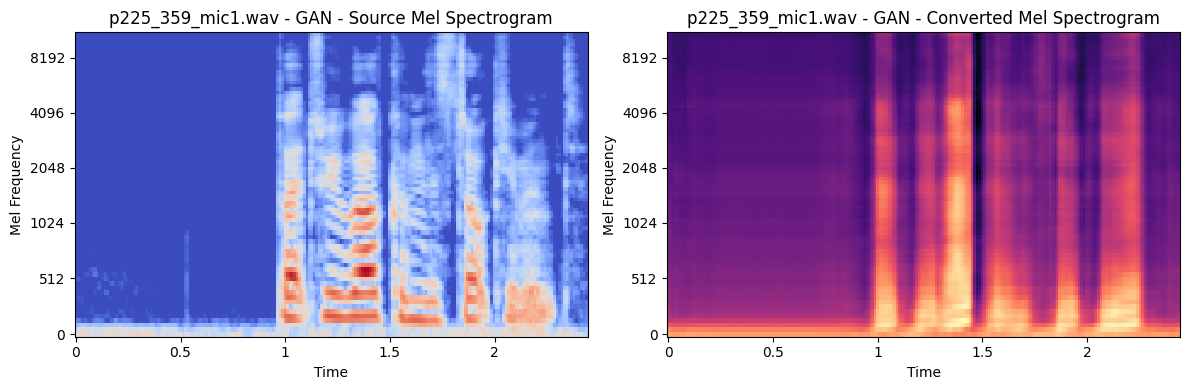


--- Original ---


--- Converted (GAN) ---



=== Processing: p225_365_mic1.wav ===
Converted audio saved to: /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/converted_gan/converted_p225_365_mic1.wav


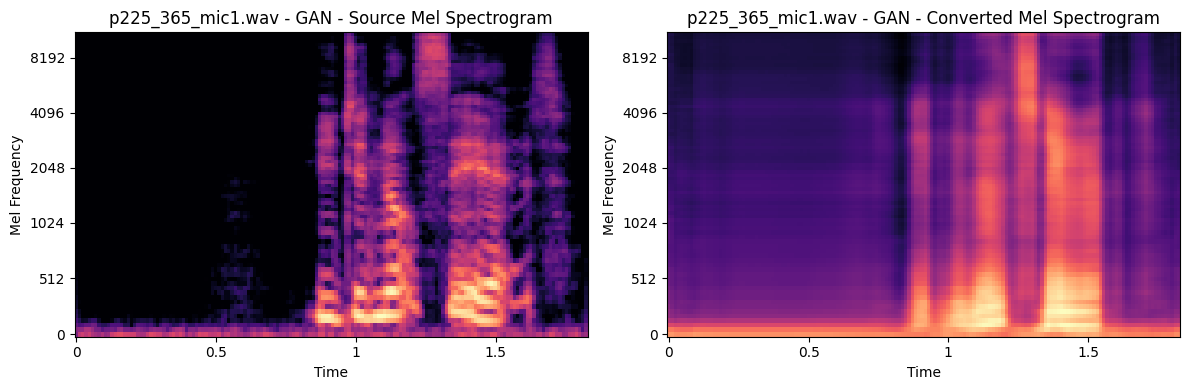


--- Original ---


--- Converted (GAN) ---



=== Processing: p225_363_mic1.wav ===
Converted audio saved to: /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/converted_gan/converted_p225_363_mic1.wav


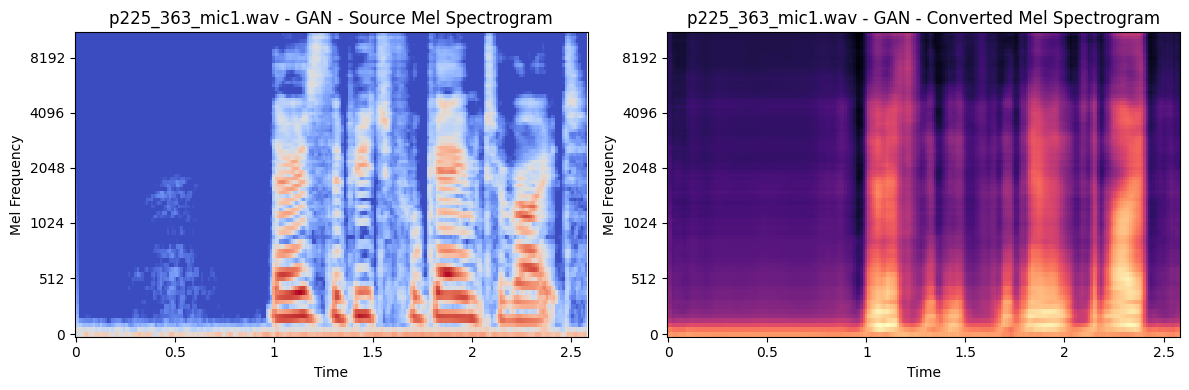


--- Original ---


--- Converted (GAN) ---



=== Processing: p225_366_mic1.wav ===
Converted audio saved to: /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/converted_gan/converted_p225_366_mic1.wav


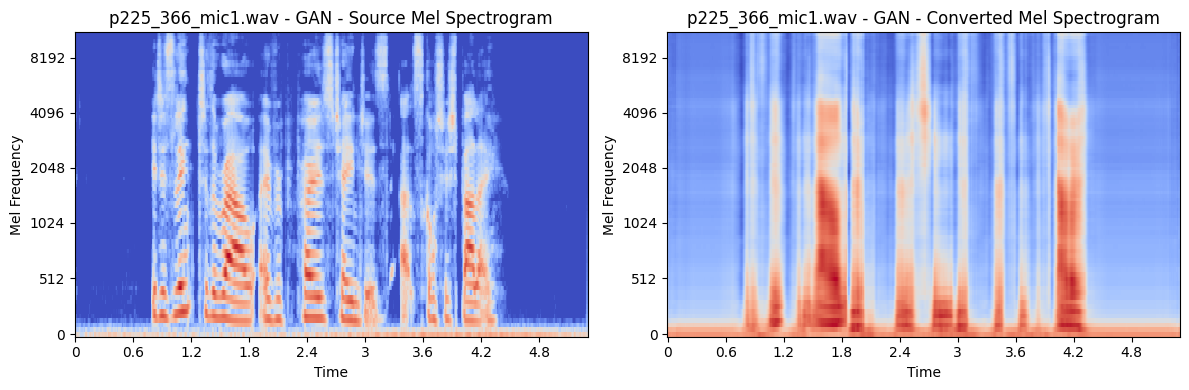


--- Original ---


--- Converted (GAN) ---



=== Processing: p225_358_mic1.wav ===
Converted audio saved to: /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/converted_gan/converted_p225_358_mic1.wav


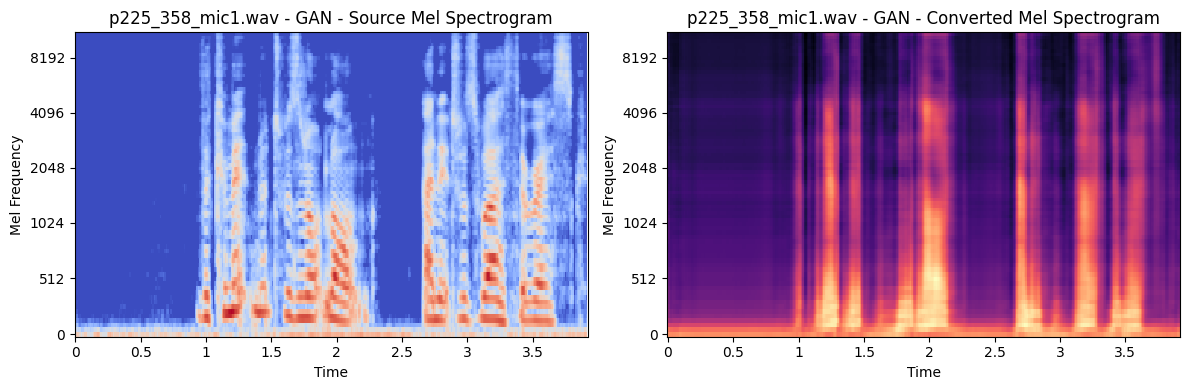


--- Original ---


--- Converted (GAN) ---


Found 5 files to convert
Converted audio saved to: /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/converted/converted_p225_359_mic1.wav
[1/5] Converted: p225_359_mic1.wav
Converted audio saved to: /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/converted/converted_p225_365_mic1.wav
[2/5] Converted: p225_365_mic1.wav
Converted audio saved to: /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/converted/converted_p225_363_mic1.wav
[3/5] Converted: p225_363_mic1.wav
Converted audio saved to: /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/converted/converted_p225_366_mic1.wav
[4/5] Converted: p225_366_mic1.wav
Converted audio saved to: /home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/converted/converted_p225_358_mic1.wav
[5/5] Converted: p225_358_mic1.wav


: 

In [ ]:
# inference_vc_gan.py - Inference with GAN-trained model

%matplotlib inline

SR = 22050
HOP = 256
N_FFT = 1024
WIN = 1024
N_MELS = 80
FMIN = 0
FMAX = 8000
device = "cuda" if torch.cuda.is_available() else "cpu"


def load_hifigan_model(checkpoint=GEN_PATH, config=CFG_PATH, device=device):
    """
    Load HiFi-GAN vocoder from checkpoint and config.
    Returns the vocoder model on the requested device.
    """
    import json
    from env import AttrDict
    from models import Generator

    with open(config, "r") as f:
        cfg = json.load(f)
    h = AttrDict(cfg)

    vocoder = Generator(h).to(device)
    state = torch.load(checkpoint, map_location=device)

    # support checkpoints that store {"generator": state_dict} or raw state_dict
    if isinstance(state, dict) and "generator" in state:
        vocoder.load_state_dict(state["generator"])
    else:
        vocoder.load_state_dict(state)

    vocoder.eval()
    # remove weight norm if model defines that method (as in HiFi-GAN)
    if hasattr(vocoder, "remove_weight_norm"):
        vocoder.remove_weight_norm()

    return vocoder

vocoder = load_hifigan_model()

def wav_to_mel(path, sr=22050, n_fft=1024, hop_length=256, n_mels=80):
    y, _ = librosa.load(path, sr=sr)
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    mel = np.log(np.clip(mel, a_min=1e-5, a_max=None))  # log-mel
    mel_tensor = torch.tensor(mel).unsqueeze(0).to(device)  # [1, 80, T]
    return mel_tensor, mel, y

def mel_to_wav(mel, vocoder, sr=SR):
    """
    Convert mel spectrogram to waveform using HiFi-GAN
    mel: numpy (n_mels, T) or torch tensor [1, n_mels, T] or [n_mels, T]
    returns: numpy waveform (float32) normalized to [-1,1]
    """
    if isinstance(mel, np.ndarray):
        if mel.ndim == 2:
            mel_t = torch.from_numpy(mel).unsqueeze(0).float().to(device)
        elif mel.ndim == 3:
            mel_t = torch.from_numpy(mel).float().to(device)
        else:
            raise ValueError("Unexpected mel shape")
    elif isinstance(mel, torch.Tensor):
        mel_t = mel.float().to(device)
        if mel_t.dim() == 2:
            mel_t = mel_t.unsqueeze(0)
    else:
        raise TypeError("mel must be numpy or torch tensor")

    with torch.no_grad():
        audio = vocoder(mel_t).cpu().squeeze().numpy()
    
    # Normalize audio
    audio = audio / (np.max(np.abs(audio)) + 1e-9)
    return audio.astype(np.float32)


def convert_voice(source_path, generator, vocoder, output_path='converted.wav'):
    """
    Main voice conversion function

    Args:
        source_path: path to source audio file
        generator: trained MelMapper model
        vocoder: HiFi-GAN vocoder
        output_path: where to save converted audio

    Returns:
        original_audio, converted_audio, source_mel, converted_mel
    """
    # Load source audio and extract mel
    # wav_to_mel returns (mel_tensor, mel_numpy, waveform)
    mel_tensor, mel_src, y_src = wav_to_mel(source_path)

    # ensure tensor is float and on the correct device
    if isinstance(mel_tensor, torch.Tensor):
        mel_tensor = mel_tensor.float().to(device)
    else:
        mel_tensor = torch.from_numpy(mel_tensor).unsqueeze(0).float().to(device)

    # Apply voice conversion
    generator.eval()
    with torch.no_grad():
        mel_converted = generator(mel_tensor)

    # Convert to waveform
    wav_converted = mel_to_wav(mel_converted, vocoder)

    # Save converted audio
    sf.write(output_path, wav_converted, SR)
    print(f"Converted audio saved to: {output_path}")

    return y_src, wav_converted, mel_src, mel_converted.cpu().numpy()[0]



def visualize_conversion(mel_src, mel_converted, title_prefix=""):
    """Visualize source and converted mel spectrograms"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Source mel
    librosa.display.specshow(mel_src, sr=SR, hop_length=HOP, 
                            x_axis='time', y_axis='mel', ax=axes[0])
    axes[0].set_title(f"{title_prefix}Source Mel Spectrogram")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Mel Frequency")
    
    # Converted mel
    librosa.display.specshow(mel_converted, sr=SR, hop_length=HOP,
                            x_axis='time', y_axis='mel', ax=axes[1])
    axes[1].set_title(f"{title_prefix}Converted Mel Spectrogram")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("Mel Frequency")
    
    plt.tight_layout()
    plt.show()

# ==================
# Load trained model
# ==================
generator = MelGenerator(n_mels=80, hidden=512).to(device)

# Load checkpoint (use the best performing epoch)
checkpoint_path = '/home/adambtw/Projects/salmaspect/voice-conversion-gan/gan_checkpoints/generator_epoch40.pt'
generator.load_state_dict(torch.load(checkpoint_path, map_location=device))
generator.eval()

print(f"Loaded generator from: {checkpoint_path}")
print(f"Using device: {device}")

# ==================
# Perform inference
# ==================
import os
from IPython.display import Audio, display

SOURCE_DIR = '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_A/test'
OUTPUT_DIR = '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/converted_gan'
os.makedirs(OUTPUT_DIR, exist_ok=True)

results = []  # to store dictionaries for later use

for fname in os.listdir(SOURCE_DIR):
    if not fname.endswith('.wav'):
        continue

    source_wav = os.path.join(SOURCE_DIR, fname)
    output_wav = os.path.join(OUTPUT_DIR, f'converted_{fname}')

    print(f"\n=== Processing: {fname} ===")

    # Convert using your existing function
    y_orig, wav_converted, mel_orig, mel_converted = convert_voice(
        source_wav,
        generator,
        vocoder,
        output_path=output_wav
    )

    # Save results for later
    results.append({
        "file": fname,
        "y_orig": y_orig,
        "wav_converted": wav_converted,
        "mel_orig": mel_orig,
        "mel_converted": mel_converted,
        "output_wav": output_wav
    })

    # Optional: visualize
    visualize_conversion(mel_orig, mel_converted, title_prefix=f"{fname} - GAN - ")

    # Optional: audio playback
    print("\n--- Original ---")
    display(Audio(y_orig, rate=SR))

    print("--- Converted (GAN) ---")
    display(Audio(wav_converted, rate=SR))


""" # ==================
# Batch processing (optional)
# ==================
def batch_convert(input_folder, output_folder, generator, vocoder):
    Convert all wav files in a folder
    import os
    import glob
    
    os.makedirs(output_folder, exist_ok=True)
    wav_files = glob.glob(os.path.join(input_folder, '*.wav'))
    
    print(f"Found {len(wav_files)} files to convert")
    
    for i, wav_path in enumerate(wav_files):
        basename = os.path.basename(wav_path)
        output_path = os.path.join(output_folder, f"converted_{basename}")
        
        try:
            _, _, _, _ = convert_voice(wav_path, generator, vocoder, output_path)
            print(f"[{i+1}/{len(wav_files)}] Converted: {basename}")
        except Exception as e:
            print(f"[{i+1}/{len(wav_files)}] Failed to convert {basename}: {e}")

# Example batch conversion:
batch_convert(
    '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_A/test',
    '/home/adambtw/Projects/salmaspect/voice-conversion-gan/data2/speaker_B/converted',
    generator,
    vocoder 
)"""

: 

: 

: 